## Load the dataset

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# adjust the separator to tab if your data is tab-separated
normalized_data_path = '../Normalization/UCI_Real_Estate_normalized.csv'
data = pd.read_csv(normalized_data_path, sep=',', header=0)

# print the first few rows of the DataFrame to verify correct loading
print(data.head())



   No  X1 transaction date  X2 house age  \
0   1             0.272727      0.730594   
1   2             0.272727      0.445205   
2   3             1.000000      0.303653   
3   4             0.909091      0.303653   
4   5             0.181818      0.114155   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                0.009513                              1.0   
1                                0.043809                              0.9   
2                                0.083315                              0.5   
3                                0.083315                              0.5   
4                                0.056799                              0.5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     0.616941      0.719323                        37.9  
1     0.584949      0.711451                        42.2  
2     0.671231      0.758896                        47.3  
3     0.671231      0.758896  

## Data Preprocessing

In [10]:
data = data.drop(['No'], axis=1)

X = data.drop('Y house price of unit area', axis=1)  # all columns except the target
y = data['Y house price of unit area']  # only the target column


# split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# display the shape of the train and test sets to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (331, 6) (331,)
Testing set shape: (83, 6) (83,)


## Model Training

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def create_model(num_layers, layer_structure, num_epochs, learning_rate, momentum, activation_function):
    model = tf.keras.Sequential()
    
    # add hidden layers as specified in layer_structure
    for i, units in enumerate(layer_structure[:-1]):  # exclude the last element for the output layer
        if i == 0:  # first layer needs to specify input shape
            model.add(tf.keras.layers.Dense(units, activation=activation_function, input_shape=(X_train.shape[1],)))
        else:
            model.add(tf.keras.layers.Dense(units, activation=activation_function))
    
    # output layer with 1 unit for regression
    model.add(tf.keras.layers.Dense(1, activation='linear'))  # ensure this matches your regression task
    
    if momentum is not None:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model, num_epochs

# example configurations 
configs = [
    {'num_layers': 2, 'layer_structure': [64, 32], 'num_epochs': 100, 'learning_rate': 0.01, 'momentum': 0.9, 'activation_function': 'relu'},
    {'num_layers': 3, 'layer_structure': [128, 64, 32], 'num_epochs': 150, 'learning_rate': 0.001, 'momentum': None, 'activation_function': 'relu'},
    {'num_layers': 2, 'layer_structure': [32, 16], 'num_epochs': 200, 'learning_rate': 0.1, 'momentum': None, 'activation_function': 'relu'},
    # {'num_layers': 3, 'layer_structure': [64, 64, 64], 'num_epochs': 100, 'learning_rate': 0.01, 'momentum': 0.8, 'activation_function': 'tanh'},
    # {'num_layers': 1, 'layer_structure': [64], 'num_epochs': 50, 'learning_rate': 0.01, 'momentum': 0.9, 'activation_function': 'sigmoid'},
    # {'num_layers': 4, 'layer_structure': [128, 128, 64, 32], 'num_epochs': 100, 'learning_rate': 0.005, 'momentum': 0.9, 'activation_function': 'relu'},
]

results = []

for config in configs:
    model, num_epochs = create_model(**config)
    # train the model and save the history
    history = model.fit(X_train, y_train, epochs=num_epochs, validation_split=0.1, verbose=0)
    
    # evaluate the model on the test set
    mse = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test).reshape(-1)
    
    # calculate test MAPE
    y_test_np = np.array(y_test).flatten()
    test_ape = np.abs((y_test_np - y_pred) / np.maximum(np.abs(y_test_np), 1e-6))
    test_mape = 100 * np.mean(test_ape)
    
    # calculate training MAPE using the training data predictions and actual values
    y_train_pred = model.predict(X_train).reshape(-1)
    y_train_np = np.array(y_train).flatten()
    train_ape = np.abs((y_train_np - y_train_pred) / np.maximum(np.abs(y_train_np), 1e-6))
    train_mape = 100 * np.mean(train_ape)
    
    # append both training and test MAPE to the results
    results.append({'config': config, 'mse': mse, 'test_mape': test_mape, 'train_mape': train_mape})

# sort and find the best and worst configurations
sorted_results = sorted(results, key=lambda x: x['mse'])
print("Best Configuration:", sorted_results[0])
print("Worst Configuration:", sorted_results[-1])



11/11 [==============================] - 0s 1ms/step


11/11 [==============================] - 0s 560us/step


11/11 [==============================] - 0s 741us/step
Best Configuration: {'config': {'num_layers': 2, 'layer_structure': [32, 16], 'num_epochs': 200, 'learning_rate': 0.1, 'momentum': None, 'activation_function': 'relu'}, 'mse': 38.03187561035156, 'test_mape': 13.955439900570655, 'train_mape': 15.003780652299238}
Worst Configuration: {'config': {'num_layers': 2, 'layer_structure': [64, 32], 'num_epochs': 100, 'learning_rate': 0.01, 'momentum': 0.9, 'activation_function': 'relu'}, 'mse': 53.309600830078125, 'test_mape': 15.75602626402823, 'train_mape': 18.68335875954369}


## Visualization

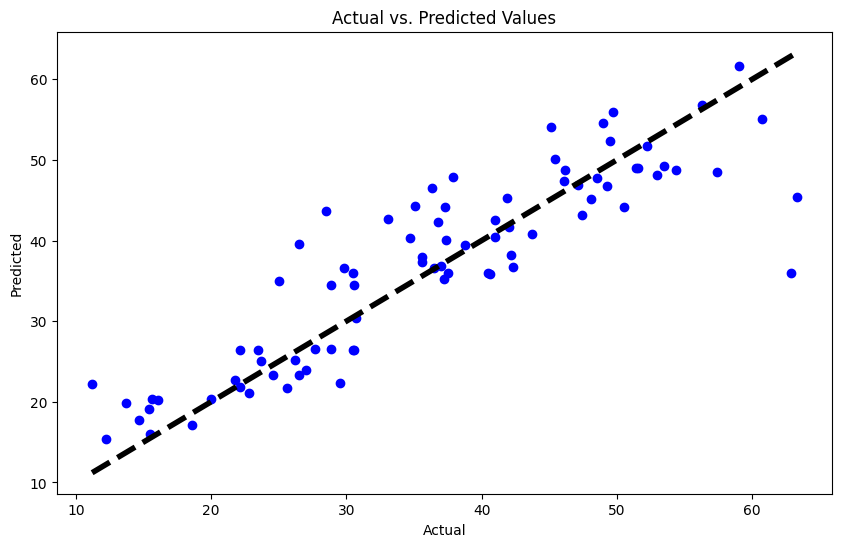

In [12]:

# plot actual vs predicted values for visual comparison

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue')  # actual values in blue
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # line for perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()
        